# A demonstration of oslo_method_python as of January 2019


Before this notebook is run on a new system, make sure to compile the Cython files by doing (in the top repo directory):

```python setup.py build_ext --inplace```

In [2]:
%load_ext autoreload
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.insert(0,"../")
import ompy as om
import copy
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


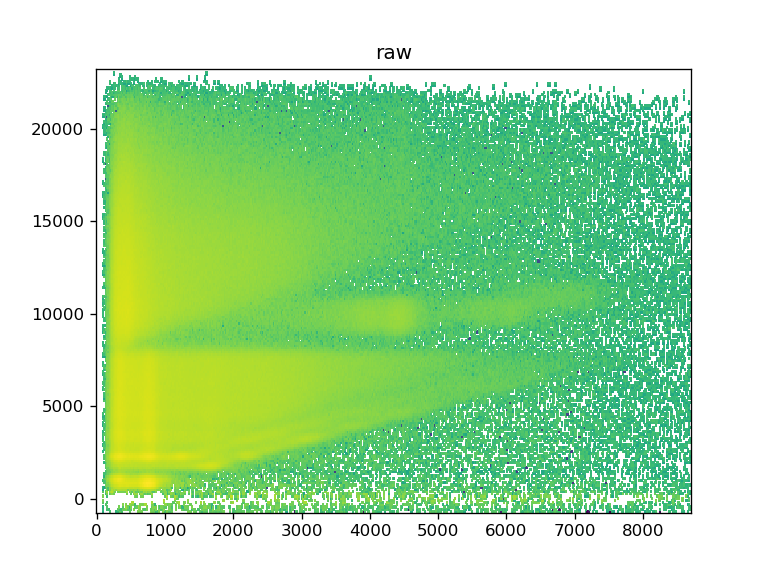

In [4]:
# Import raw matrix into instance of om.Matrix() and plot it
fname_raw = "../tests/mock/Dy164_raw.m"
raw = om.Matrix()
raw.load(fname_raw)
raw.plot(title="raw")

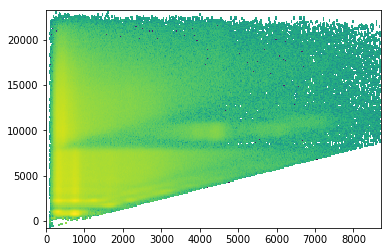

In [3]:
# Cut away diagonal
Ex1 = 0
Eg1 = 800
E1 = [Ex1, Eg1]
Ex2 = 7300
Eg2 = 7500
E2 = [Ex2, Eg2]
#raw_diagcut = copy.copy(raw)
#raw_diagcut.matrix = om.cut_diagonal(raw.matrix, raw.E0_array, raw.E1_array, E1, E2)
raw.cut_diagonal(E1, E2)
raw.plot()

<IPython.core.display.Javascript object>


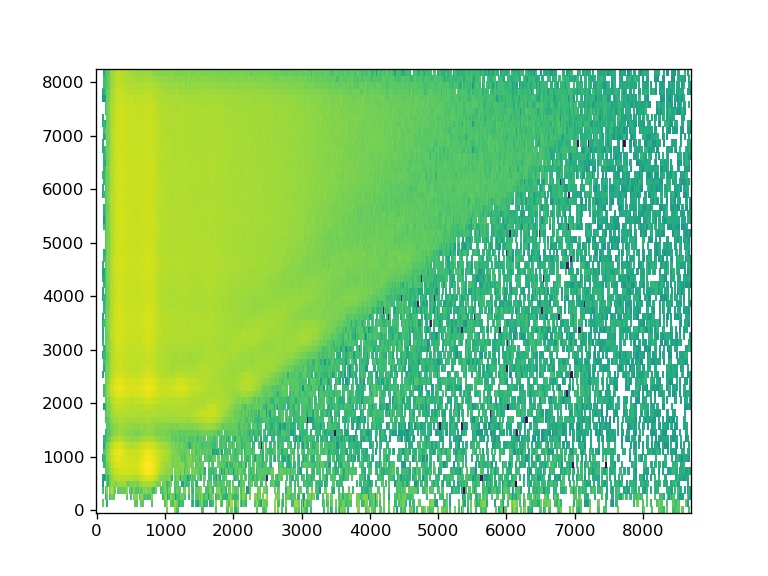

In [5]:
# Drop Ex larger than Sn, about 8300 keV
raw.cut_rect(axis=0, E_limits=[0, 8400])
raw.plot()

<IPython.core.display.Javascript object>


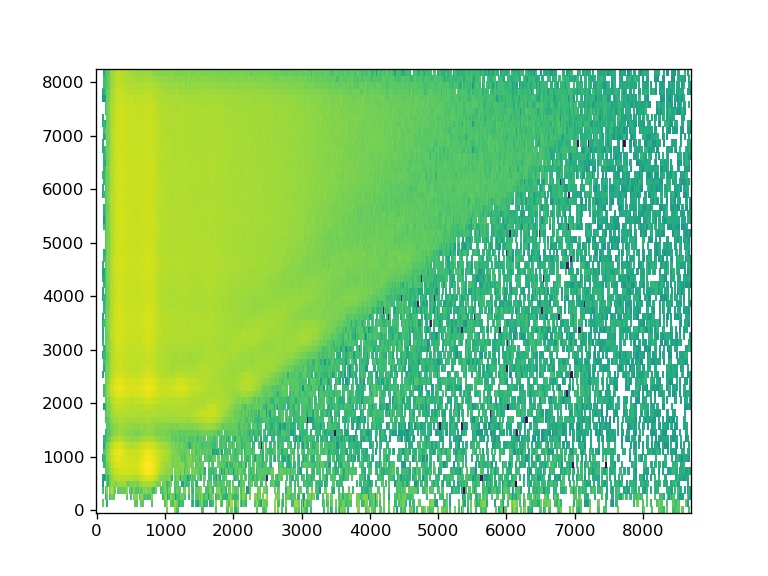

In [7]:
# Put it into an instance of om.MatrixAnalysis() to do unfolding and first generation method:
ma = om.MatrixAnalysis()
ma.raw = raw
ma.raw.plot()

In [9]:
# Unfold the matrix. 
# I haven't implemented a fast enough routine for response function interpolation yet,
# so we have to load response functions with the right calibration, made by MAMA, from file.
fname_resp_mat = "../tests/mock/Dy164_response_matrix.m"
fname_resp_dat = "../tests/mock/Dy164_response_parameters.dat"

# Call the unfolding algorithm:
diag_cut = {"Ex1": 0, "Eg1": 800, "Ex2": 7300, "Eg2": 7500}
ma.unfold(fname_resp_dat=fname_resp_dat, fname_resp_mat=fname_resp_mat, diag_cut=diag_cut)
# The result is stored in the Matrix() instance ma.unfolded. Plot it:
ma.unfolded.plot()

AttributeError: 'matrixfaux' object has no attribute 'calibration'

Hello from the fill_negative() function. Please debug me.
-867.3435157638797


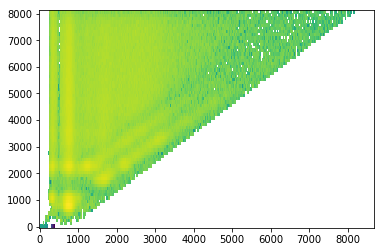

In [7]:
# Fill negative (this function requires debugging and improvements)
ma.unfolded.fill_negative(window_size=4)
print(ma.unfolded.matrix.min())
ma.unfolded.plot()

0.0


<IPython.core.display.Javascript object>


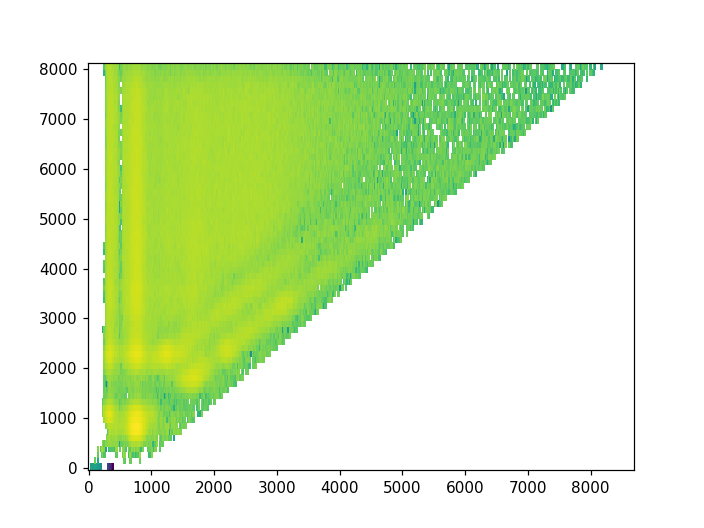

In [16]:
# Remove negatives remaining
ma.unfolded.remove_negative()
print(ma.unfolded.matrix.min())
ma.unfolded.plot()

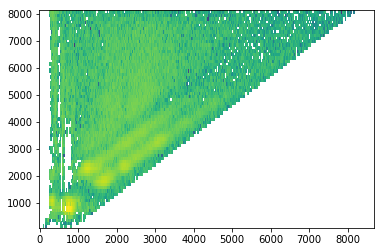

In [9]:
# Run first generation method
ma.first_generation_method(Ex_max = 8500, dE_gamma = 500)
ma.firstgen.plot(zmin=1e-3)

In [20]:
# Do error propagation in order to obtain an error matrix on the first generation spectrum
# Note that it requires an instance of MatrixAnalysis as input
ep = om.ErrorPropagation(ma, folder="error_propagation_ensemble", random_seed=481516)
ep.generate_ensemble(N_ensemble_members=10, randomness="poisson", purge_files=True)

=== Begin ensemble member  0  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  1  ===
Generating raw matrix
Unfolding matrix


../oslo_method_python/unfold.py:266: RuntimeWarning: invalid value encountered in true_divide
  fluctuations_matrix = fluctuations_matrix/fluctuations_vector_raw[:,None] # TODO check that this broadcasts the vector over the right dimension


Calculating first generation matrix
=== Begin ensemble member  2  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  3  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  4  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  5  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  6  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  7  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  8  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  9  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix


<IPython.core.display.Javascript object>


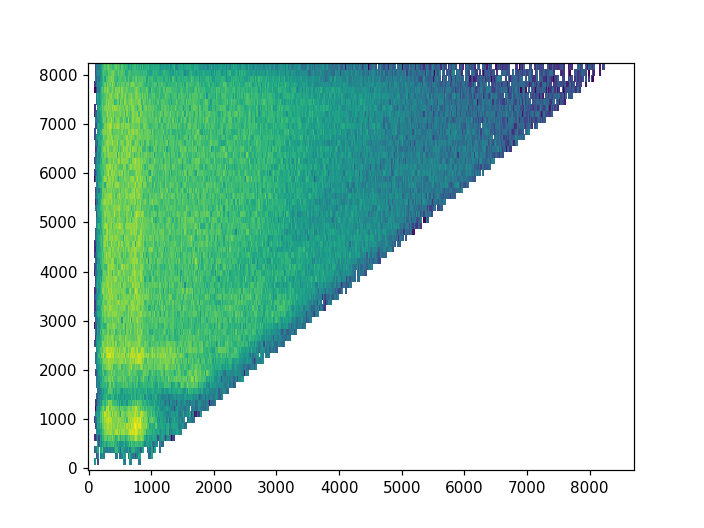

In [22]:
# Fetch and plot the standard deviation of raw:
std_raw = ep.std_raw
std_raw.plot()

<IPython.core.display.Javascript object>


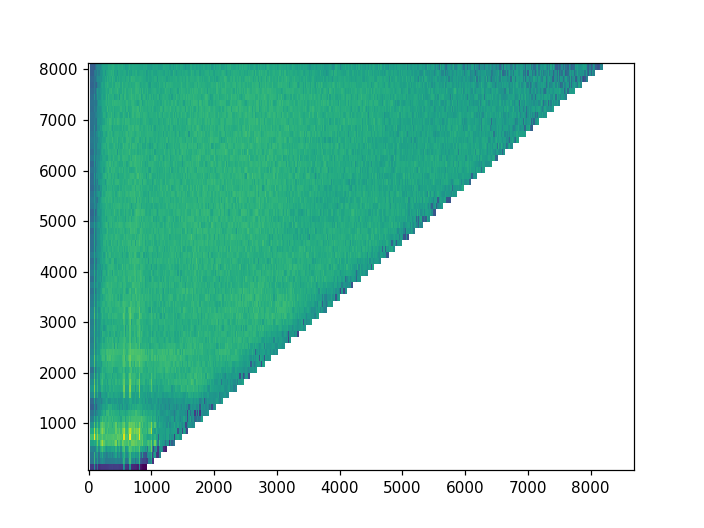

In [23]:
# Fetch and plot the standard deviation of firstgen:
std_firstgen = ep.std_firstgen
std_firstgen.plot()

res =  final_simplex: (array([[  0.23472077,   2.01790128,   2.35186567, ..., 195.9889962 ,
        -91.22019827,   2.26940613],
       [  0.23474686,   2.0179331 ,   2.35188552, ..., 195.98034275,
        -91.20482149,   2.27025956],
       [  0.23480098,   2.01790939,   2.35187254, ..., 195.97311608,
        -91.20982928,   2.27046004],
       ...,
       [  0.23501046,   2.0169976 ,   2.35159106, ..., 195.89154105,
        -91.0299126 ,   2.27688257],
       [  0.23462931,   2.01703104,   2.35159162, ..., 195.8991695 ,
        -91.04121172,   2.27650852],
       [  0.2346609 ,   2.01740928,   2.35174811, ..., 195.93459002,
        -91.09330148,   2.27435221]]), array([13147.93227039, 13147.96778651, 13147.97115634, 13147.9759566 ,
       13147.97641424, 13147.97855638, 13147.98571069, 13147.98874238,
       13147.99129545, 13147.99282901, 13147.99300138, 13147.99316254,
       13147.99724648, 13147.99844168, 13148.00151369, 13148.00435091,
       13148.00607088, 13148.01013701, 1314

<IPython.core.display.Javascript object>


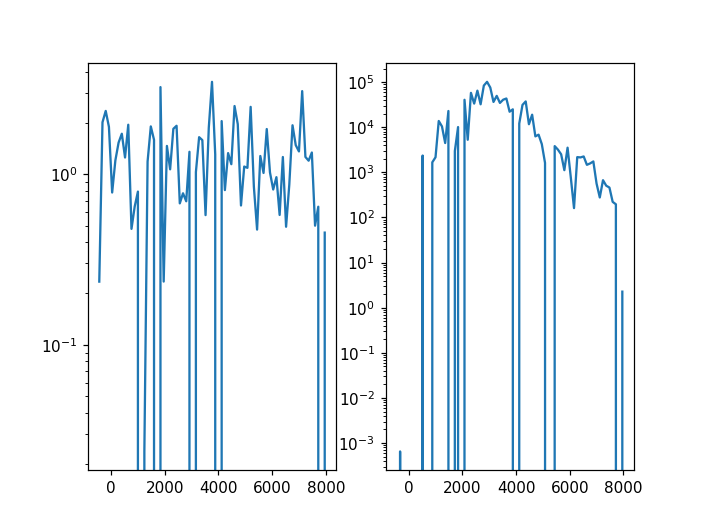

True

In [27]:
# Run fit to rho and T
# (This one needs some more bug testing...)

bin_width_out = 120
Ex_min = 3000
Ex_max = 8000
Eg_min = 1000

# Load firstgen matrix from error prop:
ma.firstgen.std = std_firstgen.matrix # TODO change the code so std_firstgen is its own input arg instead

rho, T = om.fit_rho_T(ma.firstgen, bin_width_out,
                      Ex_min, Ex_max, Eg_min,
                      method="Nelder-Mead",
                     )


f, (axrho, axT) = plt.subplots(1,2)
rho.plot(ax=axrho, yscale="log")
T.plot(ax=axT, yscale="log")